<a href="https://colab.research.google.com/github/YeisonP26/Taller-matrices/blob/main/TALLER%20MATRICES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install numpy scipy matplotlib


In [19]:
import time
import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt


In [20]:
def gaussian_elimination(A, b):
    A = A.astype(float).copy()
    b = b.astype(float).copy()
    n = A.shape[0]

    for k in range(n - 1):
        max_row = np.argmax(np.abs(A[k:, k])) + k
        if np.isclose(A[max_row, k], 0.0):
            raise np.linalg.LinAlgError("Matriz singular.")
        if max_row != k:
            A[[k, max_row], :] = A[[max_row, k], :]
            b[[k, max_row]] = b[[max_row, k]]
        for i in range(k + 1, n):
            factor = A[i, k] / A[k, k]
            A[i, k:] -= factor * A[k, k:]
            b[i] -= factor * b[k]

    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (b[i] - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]
    return x


def gauss_seidel(A, b, x0=None, tol=1e-10, max_iter=10000):
    n = A.shape[0]
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0.copy()

    for it in range(1, max_iter + 1):
        x_old = x.copy()
        for i in range(n):
            sum1 = np.dot(A[i, :i], x[:i])
            sum2 = np.dot(A[i, i+1:], x_old[i+1:])
            x[i] = (b[i] - sum1 - sum2) / A[i, i]
        if np.linalg.norm(x - x_old, ord=np.inf) < tol:
            return x, it
    return x, max_iter


def lu_solve(A, b):
    lu, piv = sla.lu_factor(A)
    return sla.lu_solve((lu, piv), b)


In [21]:
def time_it(func, *args, **kwargs):
    t0 = time.perf_counter()
    res = func(*args, **kwargs)
    t1 = time.perf_counter()
    return res, t1 - t0

def residual_norm(A, x, b):
    return np.linalg.norm(A.dot(x) - b)

def make_diagonally_dominant(n, seed=None):
    rng = np.random.default_rng(seed)
    A = rng.standard_normal((n, n))
    b = rng.standard_normal(n)
    for i in range(n):
        A[i, i] = np.sum(np.abs(A[i, :])) + 1.0
    return A, b


In [22]:
def solve_and_compare(A, b):
    results = {}

    # NumPy directo
    try:
        x_np, t_np = time_it(np.linalg.solve, A, b)
        results['numpy'] = {'time': t_np, 'residual': residual_norm(A, x_np, b)}
    except Exception as e:
        results['numpy'] = {'error': str(e)}

    # Inversa
    try:
        def inv_solve(A, b):
            return np.linalg.inv(A).dot(b)
        x_inv, t_inv = time_it(inv_solve, A, b)
        results['inverse'] = {'time': t_inv, 'residual': residual_norm(A, x_inv, b)}
    except Exception as e:
        results['inverse'] = {'error': str(e)}

    # LU
    try:
        x_lu, t_lu = time_it(lu_solve, A, b)
        results['lu'] = {'time': t_lu, 'residual': residual_norm(A, x_lu, b)}
    except Exception as e:
        results['lu'] = {'error': str(e)}

    # Gauss-Seidel
    try:
        (x_gs, its), t_gs = time_it(gauss_seidel, A, b)
        results['gauss_seidel'] = {'time': t_gs, 'residual': residual_norm(A, x_gs, b), 'iters': its}
    except Exception as e:
        results['gauss_seidel'] = {'error': str(e)}

    # Eliminación Gaussiana
    try:
        x_gauss, t_gauss = time_it(gaussian_elimination, A, b)
        results['gaussian_elimination'] = {'time': t_gauss, 'residual': residual_norm(A, x_gauss, b)}
    except Exception as e:
        results['gaussian_elimination'] = {'error': str(e)}

    return results


In [23]:
A = np.array([
    [10,  2,  3,  0,  0],
    [1,   7,  0,  1,  2],
    [2,   0,  8,  0,  1],
    [0,   1,  0,  6,  1],
    [0,   3,  1,  1,  5]
], dtype=float)

b = np.array([20, 15, 30, 14, 12], dtype=float)

results = solve_and_compare(A, b)
results


{'numpy': {'time': 0.00010779800004456774,
  'residual': np.float64(3.552713678800501e-15)},
 'inverse': {'time': 5.085799989501538e-05,
  'residual': np.float64(1.3873790429220374e-14)},
 'lu': {'time': 0.00015737400008219993,
  'residual': np.float64(3.552713678800501e-15)},
 'gauss_seidel': {'time': 0.002333399000008285,
  'residual': np.float64(1.233721426692678e-10),
  'iters': 17},
 'gaussian_elimination': {'time': 0.0008148669999172853,
  'residual': np.float64(5.329070518200751e-15)}}


=== Resultados para matriz de tamaño 3x3 ===
  numpy: {'time': 6.783100025131716e-05, 'residual': np.float64(8.759511914735174e-16)}
  inverse: {'time': 4.7524999899906106e-05, 'residual': np.float64(4.965068306494546e-16)}
  lu: {'time': 0.00021400900004664436, 'residual': np.float64(8.759511914735174e-16)}
  gauss_seidel: {'time': 0.0007170499998210289, 'residual': np.float64(5.70174215034742e-11), 'iters': 20}
  gaussian_elimination: {'time': 0.00019995700040453812, 'residual': np.float64(8.308148362110449e-16)}

=== Resultados para matriz de tamaño 10x10 ===
  numpy: {'time': 5.3745000059279846e-05, 'residual': np.float64(6.300271117485416e-16)}
  inverse: {'time': 4.965000016454724e-05, 'residual': np.float64(5.628636387720389e-16)}
  lu: {'time': 0.0008427210000263585, 'residual': np.float64(6.300271117485416e-16)}
  gauss_seidel: {'time': 0.0017907840001498698, 'residual': np.float64(1.2843770198108706e-10), 'iters': 14}
  gaussian_elimination: {'time': 0.0007185630001913523, '

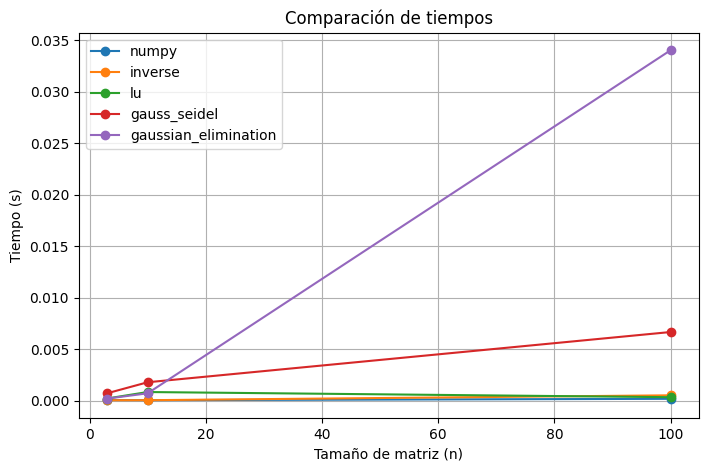

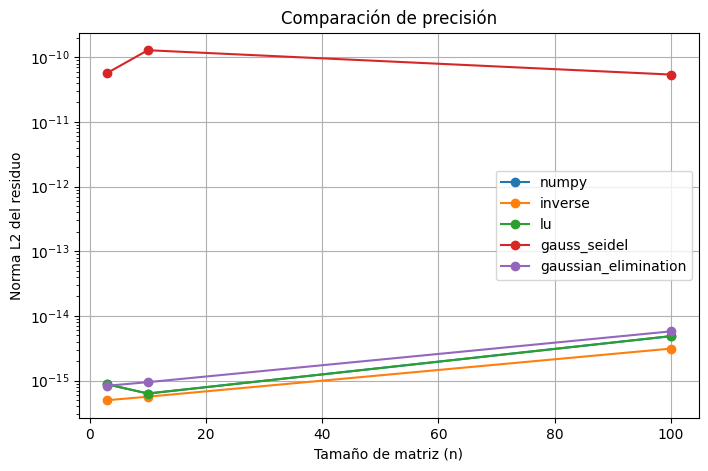

In [27]:
sizes = [3, 10, 100]
methods = ['numpy', 'inverse', 'lu', 'gauss_seidel', 'gaussian_elimination']

times = {m: [] for m in methods}
residuals = {m: [] for m in methods}

for n in sizes:
    A, b = make_diagonally_dominant(n, seed=123+n)
    res = solve_and_compare(A, b)

    # 👇 Mostrar resultados en consola
    print(f"\n=== Resultados para matriz de tamaño {n}x{n} ===")
    for m, r in res.items():
        print(f"  {m}: {r}")

    for m in methods:
        if 'error' in res[m]:
            times[m].append(np.nan)
            residuals[m].append(np.nan)
        else:
            times[m].append(res[m]['time'])
            residuals[m].append(res[m]['residual'])

# Graficar tiempos
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(sizes, times[m], marker='o', label=m)
plt.xlabel('Tamaño de matriz (n)')
plt.ylabel('Tiempo (s)')
plt.title('Comparación de tiempos')
plt.legend()
plt.grid()
plt.show()

# Graficar residuos
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(sizes, residuals[m], marker='o', label=m)
plt.xlabel('Tamaño de matriz (n)')
plt.ylabel('Norma L2 del residuo')
plt.yscale('log')
plt.title('Comparación de precisión')
plt.legend()
plt.grid()
plt.show()



=== Resultados para matriz de tamaño 3x3 ===
  numpy: {'time': 9.464499999012332e-05, 'residual': np.float64(8.759511914735174e-16)}
  inverse: {'time': 5.002999978387379e-05, 'residual': np.float64(4.965068306494546e-16)}
  lu: {'time': 0.0003077410001424141, 'residual': np.float64(8.759511914735174e-16)}
  gauss_seidel: {'time': 0.000677680000080727, 'residual': np.float64(5.70174215034742e-11), 'iters': 20}
  gaussian_elimination: {'time': 0.0002486349999344384, 'residual': np.float64(8.308148362110449e-16)}


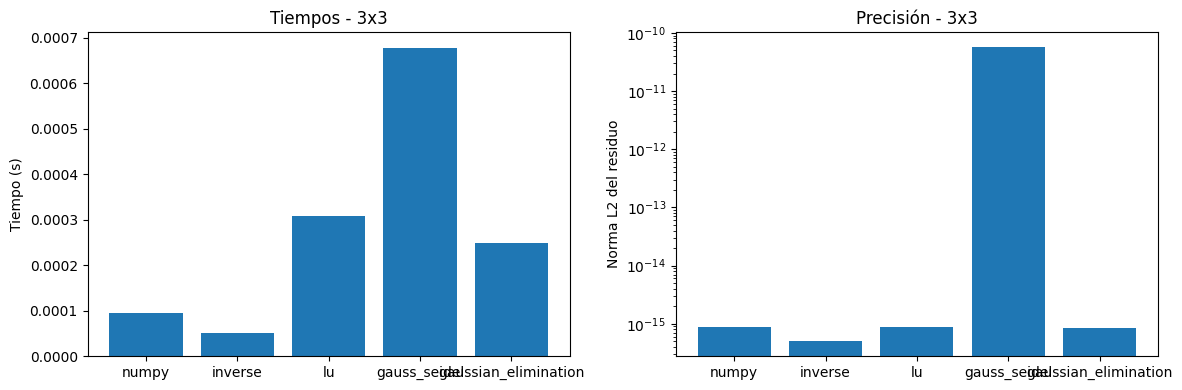

In [29]:

# PRUEBA CON MATRIZ 3x3

n = 3
A, b = make_diagonally_dominant(n, seed=123+n)
res = solve_and_compare(A, b)

print(f"\n=== Resultados para matriz de tamaño {n}x{n} ===")
for m, r in res.items():
    print(f"  {m}: {r}")

# Graficar resultados de esta matriz
methods = ['numpy', 'inverse', 'lu', 'gauss_seidel', 'gaussian_elimination']
times = [res[m]['time'] if 'error' not in res[m] else np.nan for m in methods]
residuals = [res[m]['residual'] if 'error' not in res[m] else np.nan for m in methods]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.bar(methods, times)
plt.ylabel("Tiempo (s)")
plt.title("Tiempos - 3x3")

plt.subplot(1,2,2)
plt.bar(methods, residuals)
plt.yscale("log")
plt.ylabel("Norma L2 del residuo")
plt.title("Precisión - 3x3")

plt.tight_layout()
plt.show()




=== Resultados para matriz de tamaño 10x10 ===
  numpy: {'time': 7.744399999864982e-05, 'residual': np.float64(6.300271117485416e-16)}
  inverse: {'time': 4.986000021744985e-05, 'residual': np.float64(5.628636387720389e-16)}
  lu: {'time': 0.0001777350003067113, 'residual': np.float64(6.300271117485416e-16)}
  gauss_seidel: {'time': 0.0010532790001889225, 'residual': np.float64(1.2843770198108706e-10), 'iters': 14}
  gaussian_elimination: {'time': 0.0007284769999387208, 'residual': np.float64(9.44607507504893e-16)}


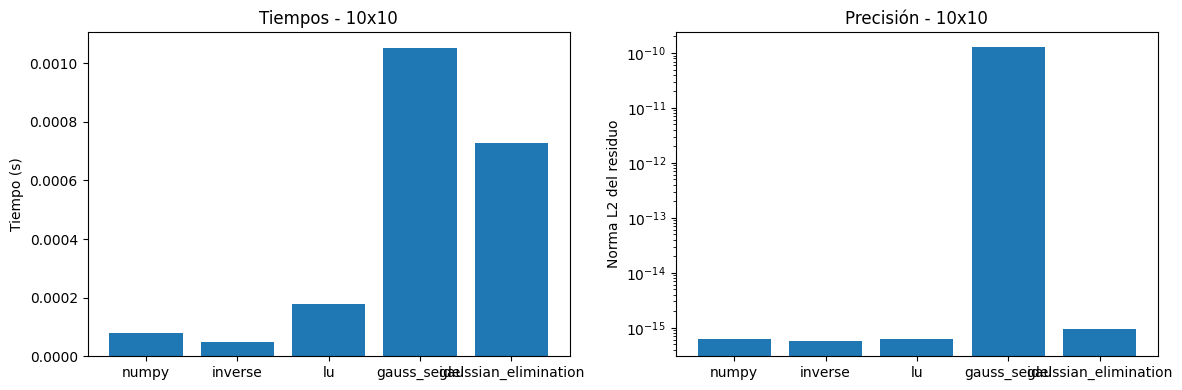

In [30]:

# PRUEBA CON MATRIZ 10x10

n = 10
A, b = make_diagonally_dominant(n, seed=123+n)
res = solve_and_compare(A, b)

print(f"\n=== Resultados para matriz de tamaño {n}x{n} ===")
for m, r in res.items():
    print(f"  {m}: {r}")

methods = ['numpy', 'inverse', 'lu', 'gauss_seidel', 'gaussian_elimination']
times = [res[m]['time'] if 'error' not in res[m] else np.nan for m in methods]
residuals = [res[m]['residual'] if 'error' not in res[m] else np.nan for m in methods]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.bar(methods, times)
plt.ylabel("Tiempo (s)")
plt.title("Tiempos - 10x10")

plt.subplot(1,2,2)
plt.bar(methods, residuals)
plt.yscale("log")
plt.ylabel("Norma L2 del residuo")
plt.title("Precisión - 10x10")

plt.tight_layout()
plt.show()



=== Resultados para matriz de tamaño 100x100 ===
  numpy: {'time': 0.004753441000048042, 'residual': np.float64(4.8565791954384535e-15)}
  inverse: {'time': 0.0006023179998919659, 'residual': np.float64(3.1200191692798303e-15)}
  lu: {'time': 0.00043973599986202316, 'residual': np.float64(4.8565791954384535e-15)}
  gauss_seidel: {'time': 0.014376447999893571, 'residual': np.float64(5.4003902511087e-11), 'iters': 9}
  gaussian_elimination: {'time': 0.08405076799999733, 'residual': np.float64(5.761087702845192e-15)}


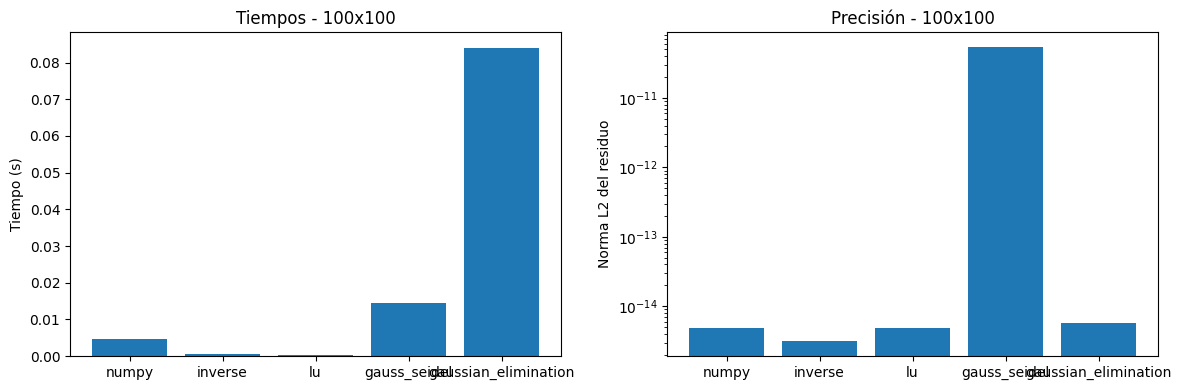

In [31]:

# PRUEBA CON MATRIZ 100x100

n = 100
A, b = make_diagonally_dominant(n, seed=123+n)
res = solve_and_compare(A, b)

print(f"\n=== Resultados para matriz de tamaño {n}x{n} ===")
for m, r in res.items():
    print(f"  {m}: {r}")

methods = ['numpy', 'inverse', 'lu', 'gauss_seidel', 'gaussian_elimination']
times = [res[m]['time'] if 'error' not in res[m] else np.nan for m in methods]
residuals = [res[m]['residual'] if 'error' not in res[m] else np.nan for m in methods]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.bar(methods, times)
plt.ylabel("Tiempo (s)")
plt.title("Tiempos - 100x100")

plt.subplot(1,2,2)
plt.bar(methods, residuals)
plt.yscale("log")
plt.ylabel("Norma L2 del residuo")
plt.title("Precisión - 100x100")

plt.tight_layout()
plt.show()
